In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!cp -r /kaggle/input/chest-xray-pneumonia /kaggle/working/chest-xray-pneumonia


In [ ]:
!find /kaggle/working/chest-xray-pneumonia/ -name "._*" -delete
!find /kaggle/working/chest-xray-pneumonia/ -name "__MACOSX" -type d -exec rm -rf {} +


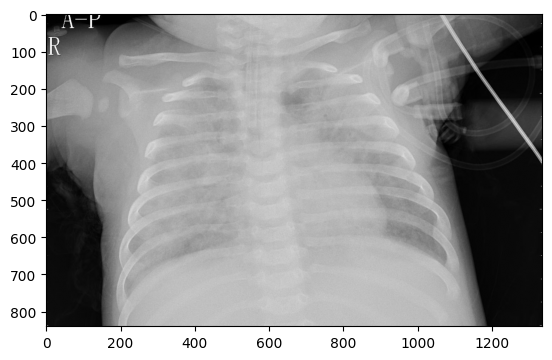

In [ ]:
img1_normal_path = r'/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg'
image = Image.open(img1_normal_path).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("Done")

Done


In [ ]:
class GeneratorModel(nn.Module):
    def __init__(self, z_dim=100, n_classes=2):
        super().__init__()
        self.z_dim = z_dim

        self.embedding = nn.Embedding(n_classes, 50)
        self.label_dense = nn.Linear(50, 4096)

        self.z_dense = nn.Linear(z_dim, 4096)

        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )

        self.out_conv = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, z, labels):
        label_embed = self.embedding(labels)
        x_label = self.label_dense(label_embed)
        x_label = x_label.view(-1, 64, 8, 8)

        x_z = self.z_dense(z)
        x_z = x_z.view(-1, 64, 8, 8)

        x = torch.cat([x_label, x_z], dim=1)
        x = self.deconv_blocks(x)
        x = self.out_conv(x)
        return self.tanh(x)

class DiscriminatorModel(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()

        self.embedding = nn.Embedding(n_classes, 50)
        self.label_dense = nn.Linear(50, 128 * 128)

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(2, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(8 * 8 * 64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, image, labels):
        label_embed = self.embedding(labels)
        y = self.label_dense(label_embed).view(-1, 1, 128, 128)
        x = torch.cat([image, y], dim=1)
        x = self.conv_blocks(x)
        x = self.flatten(x)
        x = self.drop(x)
        out = self.fc(x)
        return self.sigmoid(out)





In [ ]:
class GanModel(nn.Module):
    def __init__(self, z_dim=100, label_dim=2):
        super().__init__()
        self.generator = GeneratorModel(z_dim=z_dim, label_dim=label_dim)
        self.discriminator = DiscriminatorModel()
    def generate(self, z, label):
        return self.generator(z, label)
    def discriminate(self, img):
        return self.discriminator(img)

In [ ]:
z_dim = 100
label_dim = 2
image_size = 128
batch_size = 32
num_epochs = 150
lr = 0.0001
lambda_gp = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.BCELoss()
generator = GeneratorModel(z_dim, label_dim).to(device)
discriminator = DiscriminatorModel().to(device)
n_critic = 3
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    batch_size = real_samples.size(0)

    eps = torch.rand(batch_size, 1, 1, 1, device=real_samples.device)
    interpolated = eps * real_samples + (1 - eps) * fake_samples
    interpolated.requires_grad_(True)

    d_interpolated = D(interpolated, labels)

    grad_outputs = torch.ones_like(d_interpolated)
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gp = ((gradients.norm(2, dim=1) - 1)**2).mean()
    return gp


[0/150] Step 0 | D_loss: -0.1586 | G_loss: -0.4755
[0/150] Step 50 | D_loss: 0.1080 | G_loss: -0.7796
[0/150] Step 100 | D_loss: -0.0164 | G_loss: -0.7538
[0/150] Step 150 | D_loss: -0.2489 | G_loss: -0.6905


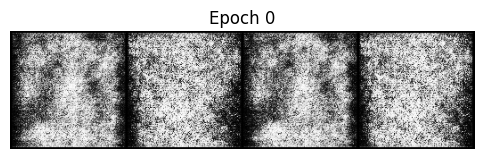

[1/150] Step 0 | D_loss: -0.3166 | G_loss: -0.6737
[1/150] Step 50 | D_loss: -0.0902 | G_loss: -0.7915
[1/150] Step 100 | D_loss: -0.0875 | G_loss: -0.6798
[1/150] Step 150 | D_loss: -0.2708 | G_loss: -0.5515
[2/150] Step 0 | D_loss: -0.4788 | G_loss: -0.3568
[2/150] Step 50 | D_loss: -0.2390 | G_loss: -0.4455
[2/150] Step 100 | D_loss: -0.3840 | G_loss: -0.4390
[2/150] Step 150 | D_loss: -0.1160 | G_loss: -0.2679
[3/150] Step 0 | D_loss: -0.2392 | G_loss: -0.2643
[3/150] Step 50 | D_loss: -0.1994 | G_loss: -0.2003
[3/150] Step 100 | D_loss: -0.0168 | G_loss: -0.4670
[3/150] Step 150 | D_loss: -0.0388 | G_loss: -0.4013
[4/150] Step 0 | D_loss: 0.0133 | G_loss: -0.4063
[4/150] Step 50 | D_loss: -0.0180 | G_loss: -0.3660
[4/150] Step 100 | D_loss: 0.0738 | G_loss: -0.4112
[4/150] Step 150 | D_loss: -0.4402 | G_loss: -0.2024
[5/150] Step 0 | D_loss: -0.4578 | G_loss: -0.1700
[5/150] Step 50 | D_loss: -0.0965 | G_loss: -0.3649
[5/150] Step 100 | D_loss: -0.2323 | G_loss: -0.3547
[5/150] St

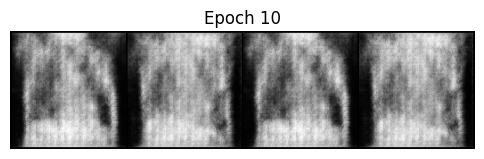

[11/150] Step 0 | D_loss: -0.4004 | G_loss: -0.2136
[11/150] Step 50 | D_loss: -0.5168 | G_loss: -0.1812
[11/150] Step 100 | D_loss: -0.5393 | G_loss: -0.1504
[11/150] Step 150 | D_loss: -0.3023 | G_loss: -0.3537
[12/150] Step 0 | D_loss: -0.4561 | G_loss: -0.2106
[12/150] Step 50 | D_loss: -0.4243 | G_loss: -0.2782
[12/150] Step 100 | D_loss: -0.4726 | G_loss: -0.2554
[12/150] Step 150 | D_loss: -0.2128 | G_loss: -0.4279
[13/150] Step 0 | D_loss: -0.2365 | G_loss: -0.3489
[13/150] Step 50 | D_loss: -0.3005 | G_loss: -0.2613
[13/150] Step 100 | D_loss: -0.4165 | G_loss: -0.1767
[13/150] Step 150 | D_loss: -0.4444 | G_loss: -0.2974
[14/150] Step 0 | D_loss: -0.5600 | G_loss: -0.2256
[14/150] Step 50 | D_loss: -0.1837 | G_loss: -0.3784
[14/150] Step 100 | D_loss: -0.3340 | G_loss: -0.2571
[14/150] Step 150 | D_loss: -0.4128 | G_loss: -0.2538
[15/150] Step 0 | D_loss: -0.4237 | G_loss: -0.2486
[15/150] Step 50 | D_loss: -0.2757 | G_loss: -0.3014
[15/150] Step 100 | D_loss: -0.1808 | G_los

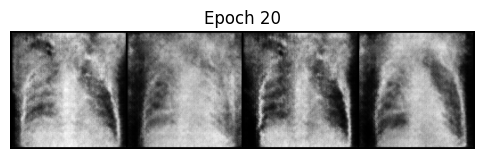

[21/150] Step 0 | D_loss: -0.4872 | G_loss: -0.1924
[21/150] Step 50 | D_loss: -0.4120 | G_loss: -0.3253
[21/150] Step 100 | D_loss: -0.1622 | G_loss: -0.4794
[21/150] Step 150 | D_loss: -0.3686 | G_loss: -0.1901
[22/150] Step 0 | D_loss: -0.4227 | G_loss: -0.1016
[22/150] Step 50 | D_loss: -0.3425 | G_loss: -0.4427
[22/150] Step 100 | D_loss: -0.2297 | G_loss: -0.4311
[22/150] Step 150 | D_loss: -0.3896 | G_loss: -0.2421
[23/150] Step 0 | D_loss: -0.4104 | G_loss: -0.3371
[23/150] Step 50 | D_loss: -0.4071 | G_loss: -0.2184
[23/150] Step 100 | D_loss: -0.6636 | G_loss: -0.1612
[23/150] Step 150 | D_loss: -0.3277 | G_loss: -0.3239
[24/150] Step 0 | D_loss: -0.2394 | G_loss: -0.3597
[24/150] Step 50 | D_loss: -0.4046 | G_loss: -0.2909
[24/150] Step 100 | D_loss: -0.5127 | G_loss: -0.4255
[24/150] Step 150 | D_loss: -0.4724 | G_loss: -0.2312
[25/150] Step 0 | D_loss: -0.4546 | G_loss: -0.3246
[25/150] Step 50 | D_loss: -0.3595 | G_loss: -0.3947
[25/150] Step 100 | D_loss: -0.3276 | G_los

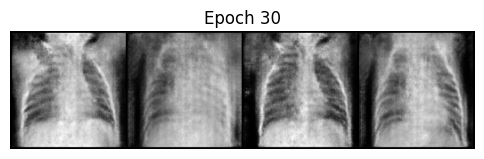

[31/150] Step 0 | D_loss: -0.4805 | G_loss: -0.2528
[31/150] Step 50 | D_loss: -0.5049 | G_loss: -0.1848
[31/150] Step 100 | D_loss: -0.5504 | G_loss: -0.4054
[31/150] Step 150 | D_loss: -0.3557 | G_loss: -0.2534
[32/150] Step 0 | D_loss: -0.4623 | G_loss: -0.2818
[32/150] Step 50 | D_loss: -0.3925 | G_loss: -0.2619
[32/150] Step 100 | D_loss: -0.2853 | G_loss: -0.3002
[32/150] Step 150 | D_loss: -0.5032 | G_loss: -0.3469
[33/150] Step 0 | D_loss: -0.4804 | G_loss: -0.5555
[33/150] Step 50 | D_loss: -0.4263 | G_loss: -0.2531
[33/150] Step 100 | D_loss: -0.4974 | G_loss: -0.1982
[33/150] Step 150 | D_loss: -0.5122 | G_loss: -0.4471
[34/150] Step 0 | D_loss: -0.3960 | G_loss: -0.2382
[34/150] Step 50 | D_loss: -0.4496 | G_loss: -0.2586
[34/150] Step 100 | D_loss: -0.4102 | G_loss: -0.2622
[34/150] Step 150 | D_loss: -0.5847 | G_loss: -0.2071
[35/150] Step 0 | D_loss: -0.6248 | G_loss: -0.2179
[35/150] Step 50 | D_loss: -0.6184 | G_loss: -0.2896
[35/150] Step 100 | D_loss: -0.5163 | G_los

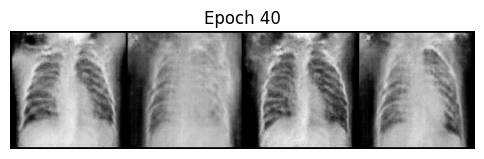

[41/150] Step 0 | D_loss: -0.4129 | G_loss: -0.3158
[41/150] Step 50 | D_loss: -0.6574 | G_loss: -0.2184
[41/150] Step 100 | D_loss: -0.5415 | G_loss: -0.2191
[41/150] Step 150 | D_loss: -0.6433 | G_loss: -0.2590
[42/150] Step 0 | D_loss: -0.4416 | G_loss: -0.1284
[42/150] Step 50 | D_loss: -0.5412 | G_loss: -0.1712
[42/150] Step 100 | D_loss: -0.6142 | G_loss: -0.2038
[42/150] Step 150 | D_loss: -0.5879 | G_loss: -0.3377
[43/150] Step 0 | D_loss: -0.6054 | G_loss: -0.2408
[43/150] Step 50 | D_loss: -0.4660 | G_loss: -0.3584
[43/150] Step 100 | D_loss: -0.6295 | G_loss: -0.2200
[43/150] Step 150 | D_loss: -0.5923 | G_loss: -0.3653
[44/150] Step 0 | D_loss: -0.6104 | G_loss: -0.1711
[44/150] Step 50 | D_loss: -0.4494 | G_loss: -0.2678
[44/150] Step 100 | D_loss: -0.5670 | G_loss: -0.2700
[44/150] Step 150 | D_loss: -0.6459 | G_loss: -0.3669
[45/150] Step 0 | D_loss: -0.5808 | G_loss: -0.1611
[45/150] Step 50 | D_loss: -0.5803 | G_loss: -0.2043
[45/150] Step 100 | D_loss: -0.5390 | G_los

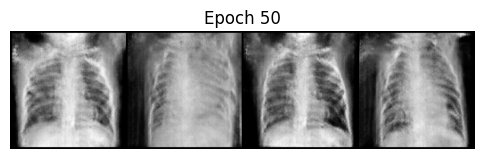

[51/150] Step 0 | D_loss: -0.6842 | G_loss: -0.0857
[51/150] Step 50 | D_loss: -0.6677 | G_loss: -0.1556
[51/150] Step 100 | D_loss: -0.6707 | G_loss: -0.2581
[51/150] Step 150 | D_loss: -0.6966 | G_loss: -0.0965
[52/150] Step 0 | D_loss: -0.1889 | G_loss: -0.3084
[52/150] Step 50 | D_loss: -0.4844 | G_loss: -0.2900
[52/150] Step 100 | D_loss: -0.7291 | G_loss: -0.0799
[52/150] Step 150 | D_loss: -0.6823 | G_loss: -0.1563
[53/150] Step 0 | D_loss: -0.5990 | G_loss: -0.2498
[53/150] Step 50 | D_loss: -0.7867 | G_loss: -0.1456
[53/150] Step 100 | D_loss: -0.5030 | G_loss: -0.0458
[53/150] Step 150 | D_loss: -0.6617 | G_loss: -0.1604
[54/150] Step 0 | D_loss: -0.7068 | G_loss: -0.1538
[54/150] Step 50 | D_loss: -0.7915 | G_loss: -0.3026
[54/150] Step 100 | D_loss: -0.7276 | G_loss: -0.1115
[54/150] Step 150 | D_loss: -0.7874 | G_loss: -0.1007
[55/150] Step 0 | D_loss: -0.4578 | G_loss: -0.3029
[55/150] Step 50 | D_loss: -0.5973 | G_loss: -0.3053
[55/150] Step 100 | D_loss: -0.5584 | G_los

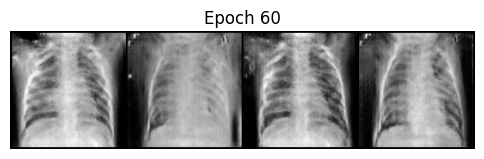

[61/150] Step 0 | D_loss: -0.5764 | G_loss: -0.3395
[61/150] Step 50 | D_loss: -0.7902 | G_loss: -0.1422
[61/150] Step 100 | D_loss: -0.4781 | G_loss: -0.1680
[61/150] Step 150 | D_loss: -0.0242 | G_loss: -0.3439
[62/150] Step 0 | D_loss: -0.3623 | G_loss: -0.3530
[62/150] Step 50 | D_loss: -0.7619 | G_loss: -0.1539
[62/150] Step 100 | D_loss: -0.5457 | G_loss: -0.3055
[62/150] Step 150 | D_loss: -0.7404 | G_loss: -0.1745
[63/150] Step 0 | D_loss: -0.7187 | G_loss: -0.1251
[63/150] Step 50 | D_loss: -0.6637 | G_loss: -0.1591
[63/150] Step 100 | D_loss: -0.6726 | G_loss: -0.2153
[63/150] Step 150 | D_loss: -0.6918 | G_loss: -0.1586
[64/150] Step 0 | D_loss: -0.7868 | G_loss: -0.1948
[64/150] Step 50 | D_loss: -0.6148 | G_loss: -0.1670
[64/150] Step 100 | D_loss: -0.8116 | G_loss: -0.1820
[64/150] Step 150 | D_loss: -0.7372 | G_loss: -0.2574
[65/150] Step 0 | D_loss: -0.7580 | G_loss: -0.1928
[65/150] Step 50 | D_loss: -0.6603 | G_loss: -0.1987
[65/150] Step 100 | D_loss: -0.6956 | G_los

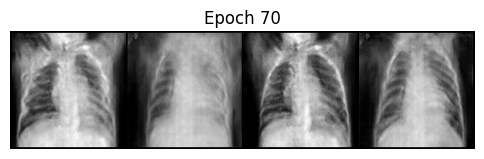

[71/150] Step 0 | D_loss: -0.7442 | G_loss: -0.1110
[71/150] Step 50 | D_loss: -0.8124 | G_loss: -0.2628
[71/150] Step 100 | D_loss: -0.7606 | G_loss: -0.0648
[71/150] Step 150 | D_loss: -0.5775 | G_loss: -0.1793
[72/150] Step 0 | D_loss: -0.1966 | G_loss: -0.2224
[72/150] Step 50 | D_loss: -0.7066 | G_loss: -0.1068
[72/150] Step 100 | D_loss: -0.7708 | G_loss: -0.0714
[72/150] Step 150 | D_loss: -0.7456 | G_loss: -0.1284
[73/150] Step 0 | D_loss: -0.7269 | G_loss: -0.0965
[73/150] Step 50 | D_loss: -0.7537 | G_loss: -0.1778
[73/150] Step 100 | D_loss: -0.7358 | G_loss: -0.3125
[73/150] Step 150 | D_loss: -0.6841 | G_loss: -0.2075
[74/150] Step 0 | D_loss: -0.7790 | G_loss: -0.0853
[74/150] Step 50 | D_loss: -0.8068 | G_loss: -0.1392
[74/150] Step 100 | D_loss: -0.7460 | G_loss: -0.3048
[74/150] Step 150 | D_loss: -0.5876 | G_loss: -0.1695
[75/150] Step 0 | D_loss: -0.5734 | G_loss: -0.1213
[75/150] Step 50 | D_loss: -0.7683 | G_loss: -0.1503
[75/150] Step 100 | D_loss: -0.8611 | G_los

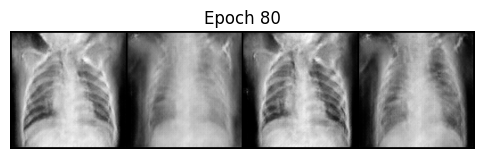

[81/150] Step 0 | D_loss: -0.7488 | G_loss: -0.2044
[81/150] Step 50 | D_loss: -0.6945 | G_loss: -0.1096
[81/150] Step 100 | D_loss: -0.7694 | G_loss: -0.2308
[81/150] Step 150 | D_loss: -0.8298 | G_loss: -0.1855
[82/150] Step 0 | D_loss: -0.7968 | G_loss: -0.1466
[82/150] Step 50 | D_loss: -0.7275 | G_loss: -0.2237
[82/150] Step 100 | D_loss: -0.7423 | G_loss: -0.1109
[82/150] Step 150 | D_loss: -0.7658 | G_loss: -0.1848
[83/150] Step 0 | D_loss: -0.6576 | G_loss: -0.3558
[83/150] Step 50 | D_loss: -0.0756 | G_loss: -0.2295
[83/150] Step 100 | D_loss: -0.4702 | G_loss: -0.3637
[83/150] Step 150 | D_loss: -0.6634 | G_loss: -0.1090
[84/150] Step 0 | D_loss: -0.8085 | G_loss: -0.0963
[84/150] Step 50 | D_loss: -0.5981 | G_loss: -0.1606
[84/150] Step 100 | D_loss: -0.7261 | G_loss: -0.1760
[84/150] Step 150 | D_loss: -0.3480 | G_loss: -0.4369
[85/150] Step 0 | D_loss: -0.8288 | G_loss: -0.2613
[85/150] Step 50 | D_loss: -0.4666 | G_loss: -0.2358
[85/150] Step 100 | D_loss: -0.7843 | G_los

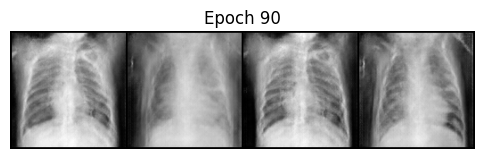

[91/150] Step 0 | D_loss: -0.7891 | G_loss: -0.2296
[91/150] Step 50 | D_loss: -0.8178 | G_loss: -0.2053
[91/150] Step 100 | D_loss: -0.8245 | G_loss: -0.1508
[91/150] Step 150 | D_loss: -0.7643 | G_loss: -0.2302
[92/150] Step 0 | D_loss: -0.7432 | G_loss: -0.1576
[92/150] Step 50 | D_loss: -0.4090 | G_loss: -0.3337
[92/150] Step 100 | D_loss: -0.7767 | G_loss: -0.2305
[92/150] Step 150 | D_loss: -0.7721 | G_loss: -0.1800
[93/150] Step 0 | D_loss: -0.7408 | G_loss: -0.1527
[93/150] Step 50 | D_loss: -0.7238 | G_loss: -0.2013
[93/150] Step 100 | D_loss: -0.7141 | G_loss: -0.0892
[93/150] Step 150 | D_loss: -0.8372 | G_loss: -0.1521
[94/150] Step 0 | D_loss: -0.7083 | G_loss: -0.2043
[94/150] Step 50 | D_loss: -0.6904 | G_loss: -0.2789
[94/150] Step 100 | D_loss: -0.4793 | G_loss: -0.3319
[94/150] Step 150 | D_loss: -0.8063 | G_loss: -0.2938
[95/150] Step 0 | D_loss: -0.7879 | G_loss: -0.1949
[95/150] Step 50 | D_loss: -0.7381 | G_loss: -0.1224
[95/150] Step 100 | D_loss: -0.7413 | G_los

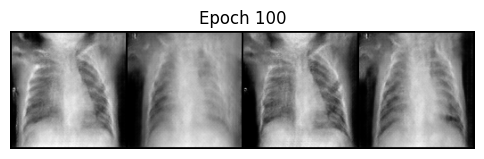

[101/150] Step 0 | D_loss: -0.8089 | G_loss: -0.2092
[101/150] Step 50 | D_loss: -0.8185 | G_loss: -0.3549
[101/150] Step 100 | D_loss: -0.7856 | G_loss: -0.1663
[101/150] Step 150 | D_loss: -0.6402 | G_loss: -0.0365
[102/150] Step 0 | D_loss: -0.8944 | G_loss: -0.0645
[102/150] Step 50 | D_loss: -0.7215 | G_loss: -0.1640
[102/150] Step 100 | D_loss: -0.6713 | G_loss: -0.2757
[102/150] Step 150 | D_loss: -0.8257 | G_loss: -0.1284
[103/150] Step 0 | D_loss: -0.6618 | G_loss: -0.1073
[103/150] Step 50 | D_loss: -0.5934 | G_loss: -0.1660
[103/150] Step 100 | D_loss: -0.6734 | G_loss: -0.3116
[103/150] Step 150 | D_loss: -0.6687 | G_loss: -0.3358
[104/150] Step 0 | D_loss: -0.5325 | G_loss: -0.3490
[104/150] Step 50 | D_loss: -0.8131 | G_loss: -0.1397
[104/150] Step 100 | D_loss: -0.7848 | G_loss: -0.2274
[104/150] Step 150 | D_loss: -0.4393 | G_loss: -0.4407
[105/150] Step 0 | D_loss: -0.5786 | G_loss: -0.2120
[105/150] Step 50 | D_loss: -0.4838 | G_loss: -0.1156
[105/150] Step 100 | D_lo

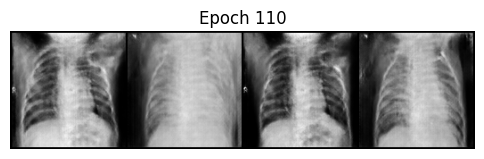

[111/150] Step 0 | D_loss: -0.7465 | G_loss: -0.1624
[111/150] Step 50 | D_loss: -0.8290 | G_loss: -0.2875
[111/150] Step 100 | D_loss: -0.8662 | G_loss: -0.1138
[111/150] Step 150 | D_loss: -0.6948 | G_loss: -0.2134
[112/150] Step 0 | D_loss: -0.8803 | G_loss: -0.1240
[112/150] Step 50 | D_loss: -0.8765 | G_loss: -0.2139
[112/150] Step 100 | D_loss: -0.8220 | G_loss: -0.1512
[112/150] Step 150 | D_loss: -0.7179 | G_loss: -0.1873
[113/150] Step 0 | D_loss: -0.6718 | G_loss: -0.3338
[113/150] Step 50 | D_loss: -0.7383 | G_loss: -0.1844
[113/150] Step 100 | D_loss: -0.7685 | G_loss: -0.2500
[113/150] Step 150 | D_loss: -0.7619 | G_loss: -0.2860
[114/150] Step 0 | D_loss: -0.8539 | G_loss: -0.2597
[114/150] Step 50 | D_loss: -0.7934 | G_loss: -0.2485
[114/150] Step 100 | D_loss: -0.8342 | G_loss: -0.2135
[114/150] Step 150 | D_loss: -0.5044 | G_loss: -0.8026
[115/150] Step 0 | D_loss: -0.3204 | G_loss: -0.4302
[115/150] Step 50 | D_loss: -0.5103 | G_loss: -0.3048
[115/150] Step 100 | D_lo

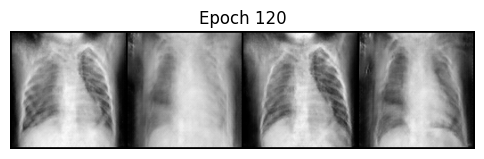

[121/150] Step 0 | D_loss: -0.7380 | G_loss: -0.1733
[121/150] Step 50 | D_loss: -0.8505 | G_loss: -0.0963
[121/150] Step 100 | D_loss: -0.7355 | G_loss: -0.2301
[121/150] Step 150 | D_loss: -0.5624 | G_loss: -0.3713
[122/150] Step 0 | D_loss: -0.7022 | G_loss: -0.1480
[122/150] Step 50 | D_loss: -0.7462 | G_loss: -0.1671
[122/150] Step 100 | D_loss: -0.7534 | G_loss: -0.0876
[122/150] Step 150 | D_loss: -0.7698 | G_loss: -0.1199
[123/150] Step 0 | D_loss: -0.8251 | G_loss: -0.1444
[123/150] Step 50 | D_loss: -0.6957 | G_loss: -0.2694
[123/150] Step 100 | D_loss: -0.8906 | G_loss: -0.1926
[123/150] Step 150 | D_loss: -0.6533 | G_loss: -0.1786
[124/150] Step 0 | D_loss: -0.1159 | G_loss: -0.5425
[124/150] Step 50 | D_loss: -0.7484 | G_loss: -0.0778
[124/150] Step 100 | D_loss: -0.7365 | G_loss: -0.1706
[124/150] Step 150 | D_loss: -0.7926 | G_loss: -0.1445
[125/150] Step 0 | D_loss: -0.8234 | G_loss: -0.1787
[125/150] Step 50 | D_loss: -0.7014 | G_loss: -0.2725
[125/150] Step 100 | D_lo

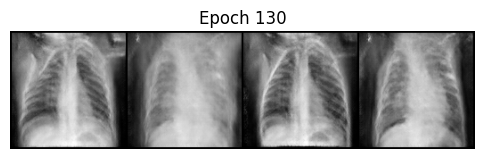

[131/150] Step 0 | D_loss: -0.7925 | G_loss: -0.3247
[131/150] Step 50 | D_loss: -0.6218 | G_loss: -0.1592
[131/150] Step 100 | D_loss: -0.4616 | G_loss: -0.2058
[131/150] Step 150 | D_loss: -0.6639 | G_loss: -0.0751
[132/150] Step 0 | D_loss: -0.8154 | G_loss: -0.1549
[132/150] Step 50 | D_loss: -0.7609 | G_loss: -0.1475
[132/150] Step 100 | D_loss: -0.7593 | G_loss: -0.2191
[132/150] Step 150 | D_loss: -0.3713 | G_loss: -0.3390
[133/150] Step 0 | D_loss: -0.5617 | G_loss: -0.2469
[133/150] Step 50 | D_loss: -0.5553 | G_loss: -0.2741
[133/150] Step 100 | D_loss: -0.6986 | G_loss: -0.2531
[133/150] Step 150 | D_loss: -0.6988 | G_loss: -0.2201
[134/150] Step 0 | D_loss: -0.8419 | G_loss: -0.1035
[134/150] Step 50 | D_loss: -0.8538 | G_loss: -0.1086
[134/150] Step 100 | D_loss: -0.5530 | G_loss: -0.4039
[134/150] Step 150 | D_loss: -0.8020 | G_loss: -0.1993
[135/150] Step 0 | D_loss: -0.7879 | G_loss: -0.1252
[135/150] Step 50 | D_loss: -0.7710 | G_loss: -0.1869
[135/150] Step 100 | D_lo

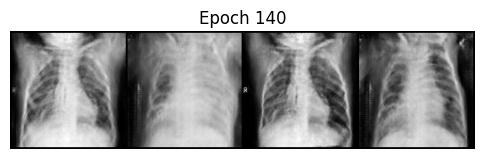

[141/150] Step 0 | D_loss: -0.8069 | G_loss: -0.1280
[141/150] Step 50 | D_loss: -0.8686 | G_loss: -0.0988
[141/150] Step 100 | D_loss: -0.6895 | G_loss: -0.2609
[141/150] Step 150 | D_loss: -0.7198 | G_loss: -0.2405
[142/150] Step 0 | D_loss: -0.6786 | G_loss: -0.2139
[142/150] Step 50 | D_loss: -0.7250 | G_loss: -0.2317
[142/150] Step 100 | D_loss: -0.8684 | G_loss: -0.1118
[142/150] Step 150 | D_loss: -0.8025 | G_loss: -0.2067
[143/150] Step 0 | D_loss: -0.8247 | G_loss: -0.2120
[143/150] Step 50 | D_loss: -0.7779 | G_loss: -0.2008
[143/150] Step 100 | D_loss: -0.8424 | G_loss: -0.1505
[143/150] Step 150 | D_loss: -0.8185 | G_loss: -0.1814
[144/150] Step 0 | D_loss: -0.7409 | G_loss: -0.2368
[144/150] Step 50 | D_loss: -0.6906 | G_loss: -0.3182
[144/150] Step 100 | D_loss: -0.8178 | G_loss: -0.2540
[144/150] Step 150 | D_loss: -0.8276 | G_loss: -0.1874
[145/150] Step 0 | D_loss: -0.6793 | G_loss: -0.3531
[145/150] Step 50 | D_loss: -0.8769 | G_loss: -0.0884
[145/150] Step 100 | D_lo

In [ ]:
import torchvision
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch_size = real_images.size(0)

        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(z, labels).detach()

            real_validity = discriminator(real_images, labels)
            fake_validity = discriminator(fake_images, labels)

            # Wasserstein loss
            d_loss_real = -real_validity.mean()
            d_loss_fake =  fake_validity.mean()
            d_loss = d_loss_real + d_loss_fake


            gp = compute_gradient_penalty(discriminator, real_images, fake_images, labels)
            d_loss_total = d_loss + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss_total.backward()
            optimizer_D.step()


        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z, labels)
        fake_validity = discriminator(fake_images, labels)
        g_loss = -fake_validity.mean()

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}] Step {i} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

    ## visualize
    if epoch == 0:
        z_fixed  = torch.randn(4, z_dim).to(device)
        labels_fixed = torch.tensor([0,1,0,1], device=device)

    if epoch % 10 == 0:
        with torch.no_grad():
            fake_samples = generator(z_fixed, labels_fixed).cpu()
            grid = torchvision.utils.make_grid(fake_samples, nrow=4, normalize=True, padding=2)
            plt.figure(figsize=(6,6))
            plt.title(f"Epoch {epoch}")
            plt.axis("off")
            plt.imshow(grid.permute(1,2,0))
            plt.show()


In [ ]:
from torchvision.utils import save_image
import zipfile
save_dir = "/content/drive/MyDrive/gen"
os.makedirs(save_dir, exist_ok=True)

# 🔧 Tham số
num_per_label = 150      # số ảnh mỗi label
z_dim = 100              # latent vector dim
num_classes = 2          # bạn có 2 label (0,1)

def generate_images(generator, z_dim, num_per_label, num_classes, save_dir):
    generator.eval()
    idx = 0
    with torch.no_grad():
        for label in range(num_classes):
            if label == 0:
                print("Haha")
                continue
            labels = torch.full((num_per_label,), label, dtype=torch.long, device=next(generator.parameters()).device)
            z = torch.randn(num_per_label, z_dim, device=labels.device)
            fake_images = generator(z, labels)

            for img in fake_images:
                save_path = os.path.join(save_dir, f"label{label}_img{idx:04d}.png")
                save_image(img * 0.5 + 0.5, save_path)  # scale [-1,1] → [0,1]
                idx += 1

# 🔥 Sinh ảnh
generate_images(generator, z_dim, num_per_label, num_classes, save_dir)

# 📦 Nén toàn bộ ảnh thành file zip
zip_path = "/content/drive/MyDrive/gen.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(save_dir):
        for file in files:
            zipf.write(os.path.join(root, file), file)

print(f"Đã lưu {num_classes*num_per_label} ảnh trong {zip_path}")

Haha
Đã lưu 300 ảnh trong /content/drive/MyDrive/gen.zip
